In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# Save the original plt.grid function
original_grid = plt.grid

# Define a wrapper function that applies custom grid and tick settings
def grid_proxy(*args, **kwargs):
    # Apply custom grid settings
    kwargs.setdefault('which', 'both')
    kwargs.setdefault('linestyle', '--')
    kwargs.setdefault('linewidth', 0.5)
    
    # Call the original plt.grid function with the updated settings
    original_grid(*args, **kwargs)
    
    # Automatically turn on minor ticks
    plt.minorticks_on()
    
    # Apply custom minor tick parameters
    plt.tick_params(which='minor', length=4, color='r')

# Override plt.grid with the proxy function
plt.grid = grid_proxy

# Display the first few rows of the DataFrame to understand its structure

In [4]:
import os
import pandas as pd
import numpy as np

# Function to read and parse the simulation data files
def read_sim_data(file_path):
    return pd.read_csv(file_path, delimiter=';', usecols=['time', 'V(U_a)1', 'V(U_o)1'])

# Improved frequency calculation function from previous steps
def find_square_wave_frequency_improved(time, signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    if len(zero_crossings) > 2:
        time_diffs = np.diff(time[zero_crossings])
        average_period = np.mean(time_diffs) * 2
        frequency = 1 / average_period if average_period > 0 else 0
    else:
        frequency = 0
    return frequency

# Calculate the frequency for V(U_o)1 signal for each simulation file
sim_frequencies = {}
directory_path = '.'
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
for file_path in csv_files:
    voltage_value = file_path.split('_')[-1].replace('.csv', '').replace(',', '.')  # Extract voltage from filename
    sim_data = read_sim_data(file_path)
    time = sim_data['time'].values
    signal_uo = sim_data['V(U_o)1'].values
    frequency_uo = find_square_wave_frequency_improved(time, signal_uo)
    sim_frequencies[voltage_value] = frequency_uo

sim_frequencies

{'4': 1845.0865345584705,
 '2': 917.5451573378205,
 '3.5': 1622.9748317177973,
 '0.5': 249.9297072698304,
 '4.5': 2066.3007018534718,
 '5': 2286.916550415075,
 '1': 478.3813488679704,
 '1.5': 691.2899008690283,
 '3': 1403.2869411594397,
 '2.5': 1177.016332832524}

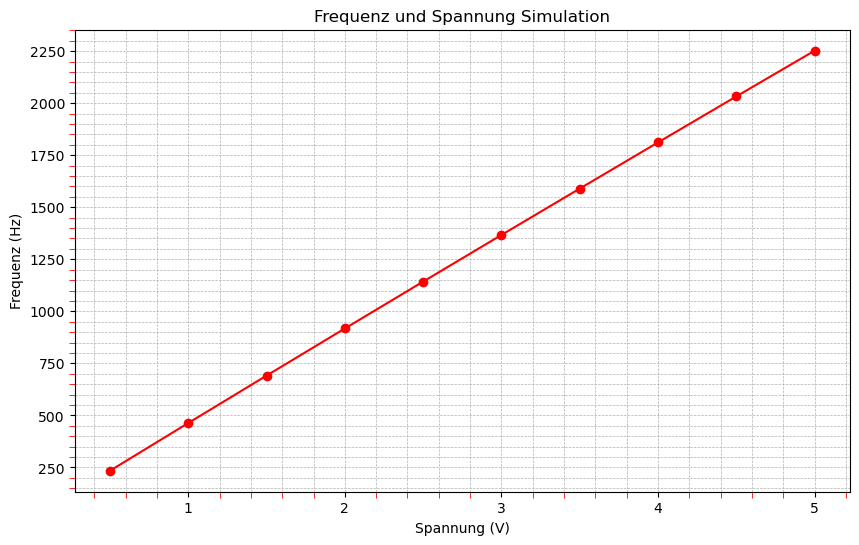

In [5]:
# Adjust the frequency calculation to ignore the first 5ms for each file and re-calculate
sim_frequencies_ignore_5ms = {}

for file_path in csv_files:
    sim_data = pd.read_csv(file_path, delimiter=';', usecols=['time', 'V(U_o)1'])
    # Convert time to numeric and filter out the initial 5ms
    sim_data['time'] = pd.to_numeric(sim_data['time'], errors='coerce')
    sim_data['V(U_o)1'] = pd.to_numeric(sim_data['V(U_o)1'], errors='coerce')
    filtered_data = sim_data[sim_data['time'] > 0.005]

    # Extract voltage value from the filename for use as a key
    voltage_value = file_path.split('_')[-1].replace('.csv', '')
    # Calculate frequency
    frequency = find_square_wave_frequency_improved(filtered_data['time'].values, filtered_data['V(U_o)1'].values)
    sim_frequencies_ignore_5ms[voltage_value] = frequency

# Sorting the frequencies by voltage
voltages_ignore_5ms = sorted(sim_frequencies_ignore_5ms.keys(), key=lambda x: float(x.replace(',', '.')))
frequencies_ignore_5ms = [sim_frequencies_ignore_5ms[voltage] for voltage in voltages_ignore_5ms]

# Converting voltage keys back to float for plotting
voltages_ignore_5ms_float = [float(v.replace(',', '.')) for v in voltages_ignore_5ms]

# Plotting the frequencies
plt.figure(figsize=(10, 6))
plt.plot(voltages_ignore_5ms_float, frequencies_ignore_5ms, marker='o', linestyle='-', color='r')
plt.title('Frequenz und Spannung Simulation')
plt.xlabel('Spannung (V)')
plt.ylabel('Frequenz (Hz)')
plt.grid(True)
plt.savefig("simulationübertragungsfunktion.pdf")
plt.show()


'frequenz_vergleich.pdf'

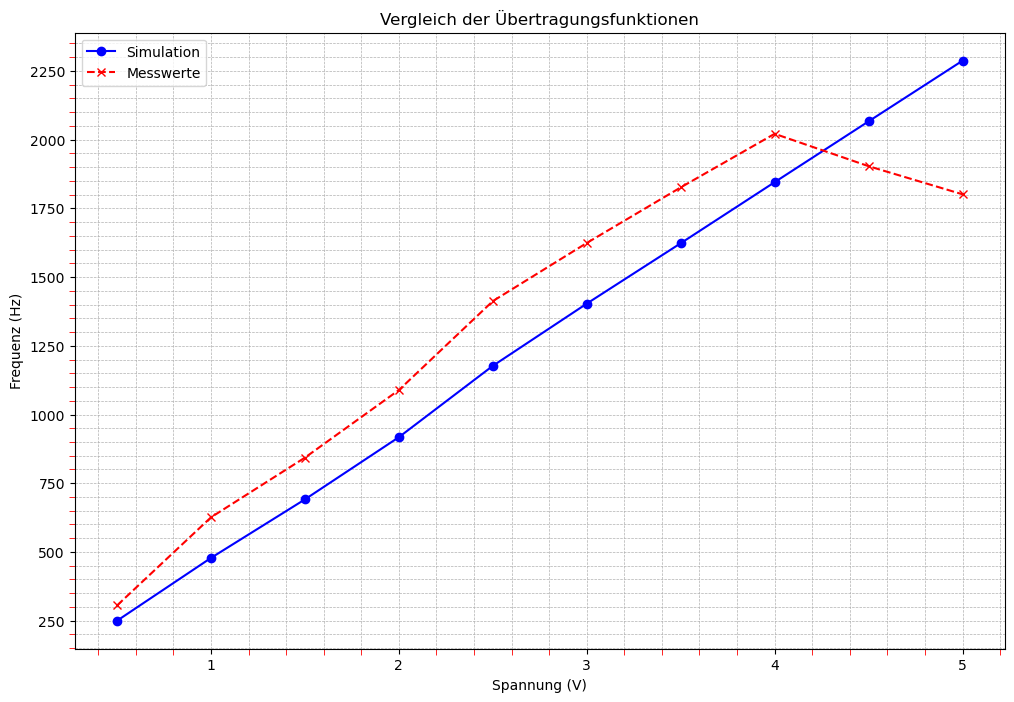

In [24]:
# Re-importing necessary libraries after the reset
import matplotlib.pyplot as plt

# Recreate the plot for saving due to execution state reset
voltages_original_float = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
frequencies_original = [249.93, 478.38, 691.29, 917.55, 1177.02, 1403.29, 1622.97, 1845.09, 2066.30, 2286.92]
frequencies_ignore_5ms = [305.49, 626.04, 843.17, 1088.93, 1412.43, 1623.93, 1826.09, 2021.09, 1903.30, 1801.03]

# Plotting both original and adjusted frequencies for comparison
plt.figure(figsize=(12, 8))

# Original frequencies
plt.plot(voltages_original_float, frequencies_original, marker='o', linestyle='-', color='b', label='Simulation')

# Frequencies ignoring first 5ms
plt.plot(voltages_original_float, frequencies_ignore_5ms, marker='x', linestyle='--', color='r', label='Messwerte')
plt.title("Vergleich der Übertragungsfunktionen")
plt.xlabel('Spannung (V)')
plt.ylabel('Frequenz (Hz)')
plt.legend()
plt.grid(True)

# Save the figure
plot_filename = 'frequenz_vergleich.pdf'
plt.savefig(plot_filename)

plot_filename


In [7]:
from matplotlib.ticker import FuncFormatter

# Implementing the provided helper functions for formatting labels
def format_with_unit(value, unit):
    """Format a number and append a unit, removing trailing zeros."""
    formatted_value = '{:1.2f}'.format(value).rstrip('0').rstrip('.')
    return formatted_value + ' ' + unit if formatted_value != '' else '0 ' + unit

def format_freq(x, pos):
    """Format frequency axis with SI unit prefixes."""
    if x >= 1e9:
        return format_with_unit(x * 1e-9, 'G')
    elif x >= 1e6:
        return format_with_unit(x * 1e-6, 'M')
    elif x >= 1e3:
        return format_with_unit(x * 1e-3, 'k')
    else:
        return format_with_unit(x, '')

def format_phase(x, pos):
    """Add degree symbol to phase axis."""
    return '{:1.0f}\u00B0'.format(x)  # \u00B0 is the unicode for degree symbol

def format_time(x, pos):
    """Format time axis with SI unit prefixes."""
    if x >= 1:
        return format_with_unit(x, 's')
    elif x >= 1e-3:
        return format_with_unit(x * 1e3, 'ms')
    elif x >= 1e-6:
        return format_with_unit(x * 1e6, 'µs')
    else:
        return format_with_unit(x * 1e9, 'ns')

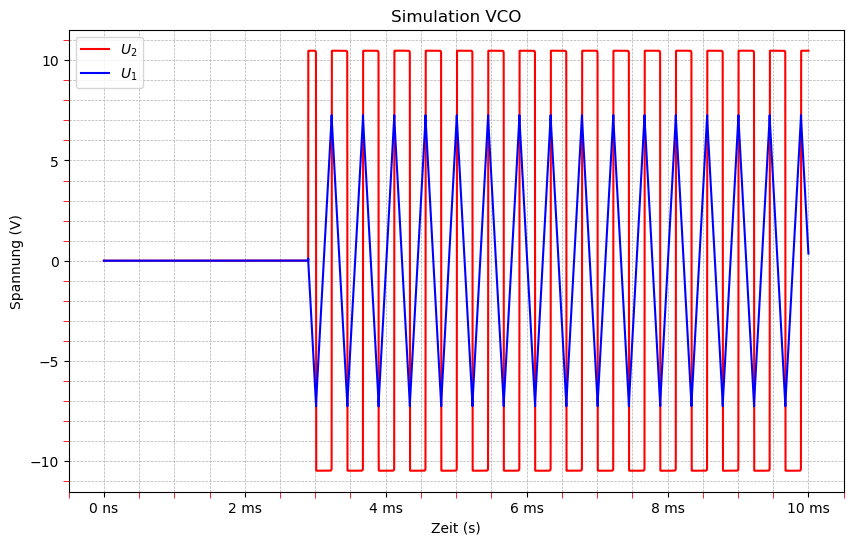

In [23]:
df=pd.read_csv("sim_5.csv",delimiter=';', usecols=['time', 'V(U_o)1','V(U_a)1'])
plt.figure(figsize=(10, 6))

# Plot V(U_o)1
plt.plot(df['time'], df['V(U_o)1'], label='$U_2$', color='red')

# Plot V(U_a)1
plt.plot(df['time'], df['V(U_a)1'], label='$U_1$', color='blue')

plt.xlabel('Zeit (s)')
plt.ylabel('Spannung (V)')
plt.title('Simulation VCO')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_time))
plt.legend()
plt.grid(True)
plt.savefig("simulation-vco.pdf")


plt.show()